In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

AttributeError: module 'numpy.typing' has no attribute 'NDArray'

In [ ]:
DATA_DIR = '/home/lichalab/DMS_seg/mydata'

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'images/train')
y_train_dir = os.path.join(DATA_DIR, 'labels/train')

x_valid_dir = os.path.join(DATA_DIR, 'images/validation')
y_valid_dir = os.path.join(DATA_DIR, 'labels/validation')

x_test_dir = os.path.join(DATA_DIR, 'images/test')
y_test_dir = os.path.join(DATA_DIR, 'labels/test')

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
# import json
# with open('/home/lichalab/DMS_seg/data/DMS_v1/taxonomy.json', 'r') as file:
#     data = json.load(file)
# class_name=data["names"]
# print(class_name)

/home/lichalab/anaconda3/envs/materobot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    # CLASSES = class_name
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls) for cls in classes]
        self.class_values = [255]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
         # 获取图像的宽度和高度
        # print(image.shape)  
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

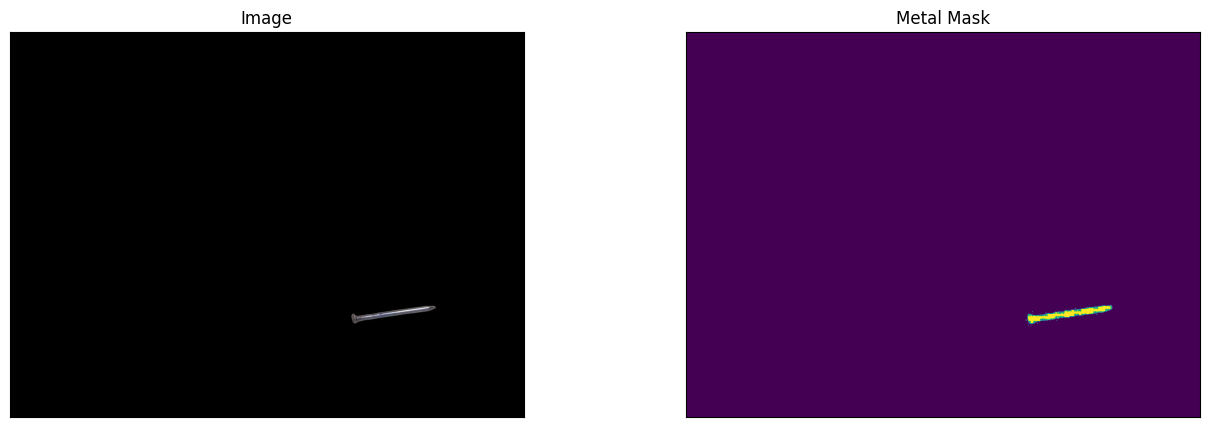

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['Metal'])

image, mask = dataset[10] # get some sample
visualize(
    image=image, 
    metal_mask=mask.squeeze(),
)

In [ ]:
import albumentations as albu
import random
import math

ModuleNotFoundError: No module named 'albumentations'

In [ ]:
def get_training_augmentation():
    print(image.shape)
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        # albu.ShiftScaleRotate(scale_limit=(-0.5, 0), rotate_limit=2, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=480, min_width=640, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=480, width=640, always_apply=True),
        albu.Resize(height=640, width=640),
        albu.ShiftScaleRotate(scale_limit=(-0.5, 0), rotate_limit=2, shift_limit=0.1, p=1, border_mode=0),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    # 获取图像的宽度和高度
    height, width = image.shape[:2]
    print(f'Height: {height}, Width: {width}')
    # 计算可以被32整除的最近的宽度和高度
    new_width = int(math.ceil(width / 32.0)) * 32
    new_height = int(math.ceil(height / 32.0)) * 32
    test_transform = [
        # albu.PadIfNeeded(min_height=new_height, min_width=new_width, always_apply=True, border_mode=0),
        albu.Resize(height=640, width=640),
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

: 

In [ ]:
#### Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['Metal'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[random.randint(0, 30)]
    visualize(image=image, mask=mask.squeeze(-1))

: 

In [ ]:
augmented_dataset2 = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    classes=['Metal'],
)
image, mask = augmented_dataset2[random.randint(0, 30)]
visualize(image=image, mask=mask.squeeze(-1))
# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset2[random.randint(0, 30)]
    visualize(image=image, mask=mask.squeeze(-1))

: 

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import ssl
from segmentation_models_pytorch import utils
DEVICE = 'cuda'
ssl._create_default_https_context = ssl._create_unverified_context

: 

In [ ]:
# ENCODER = 'resnet34'
# ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['Metal']
# ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
# DEVICE = 'cuda'

# model = smp.Unet(
#     encoder_name=ENCODER,        # 选择解码器, 例如 mobilenet_v2 或 efficientnet-b7
#     encoder_weights=ENCODER_WEIGHTS,     # 使用预先训练的权重imagenet进行解码器初始化
#     in_channels=3,                  # 模型输入通道（1个用于灰度图像，3个用于RGB等）
#     classes=1,                      # 模型输出通道（数据集所分的类别总数）
#     activation=ACTIVATION,
# )
# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

: 

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Metal']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation


model = smp.FPN(
    encoder_name=ENCODER,        # 选择解码器, 例如 mobilenet_v2 或 efficientnet-b7
    encoder_weights=ENCODER_WEIGHTS,     # 使用预先训练的权重imagenet进行解码器初始化
    in_channels=3,                  # 模型输入通道（1个用于灰度图像，3个用于RGB等）
    classes=1,                      # 模型输出通道（数据集所分的类别总数）
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

: 

In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=1)

: 

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

: 

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

: 

In [ ]:
# train model for 40 epochs

max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

: 

In [ ]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

: 

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

: 

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

: 

In [ ]:
mytest_dir = '/home/lichalab/DMS_seg/myimg'
new_size = (640, 640)  # 新的宽度和高度
# 获取目录下所有的.jpg文件
image_files = [f for f in os.listdir(mytest_dir) if f.endswith('.png')]
for image_file in image_files[-5:]:  # 只读取前5个文件
    image_path = os.path.join(mytest_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(image.shape)
    image = cv2.resize(image, new_size)
    resized_image = np.transpose(image, (2, 0, 1)).astype(np.float32)/255
    print(resized_image.shape)
    x_tensor = torch.from_numpy(resized_image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image, 
        predicted_mask=pr_mask
    )

: 

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

: 

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    print(image.shape)
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

: 